In [55]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.optimize import curve_fit
import time
import tkinter as tk
from tkinter import messagebox
import math

# our functions
import model_transition
import seir_discrete 

import warnings
warnings.filterwarnings(action='ignore')

# для учета обновлений при изменении файлов
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
I_prediction_method='seir'
seed_dirs=f'{I_prediction_method}_30_seeds_v0/'
seed_df = pd.read_csv(seed_dirs + f'{I_prediction_method}_seed_{10}.csv')
seed_df.head()

,S,E,I,R,Beta
0,9950,0,50,0,0.000006
1,9947,3,46,4,0.000013
2,9941,9,41,9,0.000010
3,9937,12,38,13,0.000011
4,9933,16,37,14,0.000016


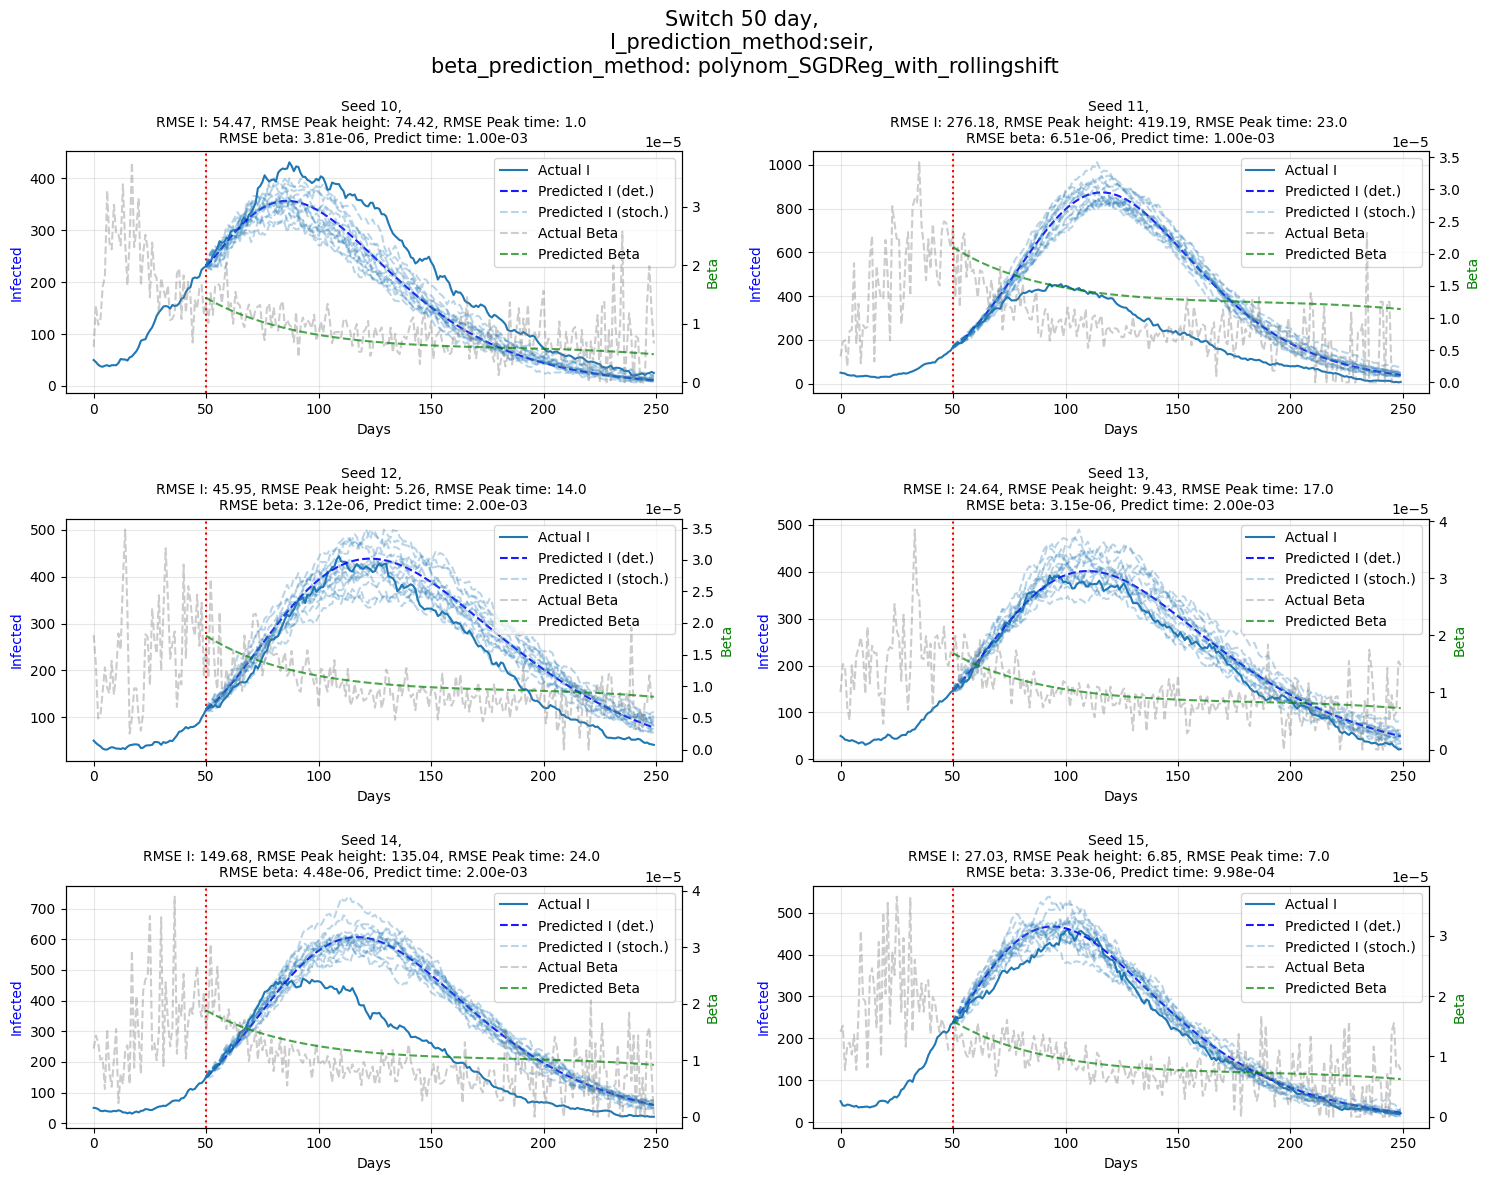

In [109]:
beta_prediction_method='polynom_SGDReg_with_rollingshift'

model_transition.main_f(I_prediction_method='seir', stochastic=True, count_stoch_line=15, 
           beta_prediction_method=beta_prediction_method, start_day=50, 
           seed_numbers=np.arange(10,16))

In [113]:
methods = ['mean_const','expanding_mean','bi_exp_decay', 'polynom_of_day', 
        'polynom_of_day_prev_I','polynom_of_day_with_shift', 'polynom_SGDReg', 
        'polynom_SGDReg_with_rollingshift','polynom_SGDReg_with_future_training']

In [152]:
from sklearn.metrics import root_mean_squared_error as rmse

rmse_ph = []
rmse_pt = []
for i in methods:
    p_df = pd.read_csv(f'peak_metrics/{i}_peaks.csv', index_col=0)
    # rmse (y true, y pred)
    rmse_ph.append(rmse(p_df.iloc[:,0], p_df.iloc[:,1]))
    rmse_pt.append(rmse(p_df.iloc[:,2], p_df.iloc[:,3]))
    print(rmse(p_df.iloc[:,0], p_df.iloc[:,1]), 
          rmse(p_df.iloc[:,2], p_df.iloc[:,3]))
# delete values for mean_const
rmse_ph.pop(1)
rmse_pt.pop(1)

567.5839158474678 30.980101140355668
371.17096970890026 24.438357828081113
445.52006495902936 17.525219922538298
179.7940358970872 14.039230748157108
177.00218096871652 9.612491872558333
283.8596821231095 19.473914175977395
144.0930218112905 14.658330964563008
291.44825301541897 13.984515246037907
117.8441271561263 16.03017987006592


24.438357828081113

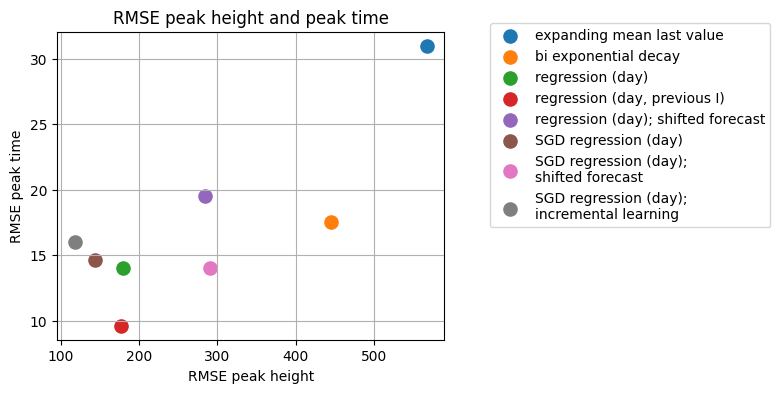

In [156]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))

new_x_labels = ['expanding mean last value', 
                #'expanding mean', 
                'bi exponential decay', 
                'regression (day)', 'regression (day, previous I)',
                    'regression (day); shifted forecast', 
                'SGD regression (day)', 'SGD regression (day);\nshifted forecast', 
                    'SGD regression (day);\nincremental learning']


for i, name in enumerate(new_x_labels):   
    ax.scatter(rmse_ph[i], rmse_pt[i], marker='o', s=90, label=name)
    
ax.set_title('RMSE peak height and peak time')    
ax.set_xlabel('RMSE peak height')
ax.set_ylabel('RMSE peak time')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.grid()

plt.savefig(f'rmse_peaks.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [157]:
import LSTM_model_code

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
!pip install tensorflow

# interface

In [3]:
'''
Создание графического окна для ввода параметров
'''
def parse_seeds(seeds_input):
    ''' 
    Сортировка numbers of seeds
    '''

    # использование множества уникальных значений
    seeds = set()  
   
    parts = seeds_input.split(',') 
    for part in parts:
        if '-' in part:  # определение диапазона по тире
            start, end = part.split('-')
            seeds.update(range(int(start), int(end)))  # добавление чисел из диапазона
        else:
            seeds.add(int(part))  # добавление отдельных номеров seed
            
    return sorted(seeds)

def calculate():
    try:
        # получение значениий из полей ввода
        I_prediction_method = var_I_prediction_method.get()
        stochastic = var_stochastic.get()
        # получение количества случайных траекторий, если включена стохастичность
        count_stoch_line = int(entry_count_stoch_line.get()) if stochastic else 0  
        beta_prediction_method = var_beta_prediction_method.get()
        start_day = int(entry_start_day.get())
        seed_numbers = entry_seed_numbers.get()

        # сортировка numbers of seeds
        seed_numbers = parse_seeds(seed_numbers)
        
        # вызов основной функции
        result = main_f(I_prediction_method, stochastic, count_stoch_line, 
                        beta_prediction_method, start_day, seed_numbers)
        
        # вывод результата
        messagebox.showinfo("Результат", result)
    except ValueError:
        messagebox.showerror("Ошибка", "Пожалуйста, введите корректные данные.")
    except Exception as e:
        messagebox.showerror("Ошибка", f"Произошла ошибка: {str(e)}")

# создание главного окна
root = tk.Tk()
root.title("Ввод параметров")

# создание переменной для выбора мат. модели
var_I_prediction_method = tk.StringVar(value="seir")  # установка значения по умолчанию
# создание выпадающего списока для выбора мат. модели
label_I_prediction_method = tk.Label(root, text="Метод предсказания Infected:")
label_I_prediction_method.pack()
I_prediction_method_options = ["seir", "sir"]
dropdown_I_prediction_method = tk.OptionMenu(root, var_I_prediction_method, 
                                             *I_prediction_method_options)
dropdown_I_prediction_method.pack()

# создание флажка для стохастичности
var_stochastic = tk.BooleanVar(value=False)
checkbox_stochastic = tk.Checkbutton(root, text="Стохастичность", 
                                     variable=var_stochastic, 
                                     command=lambda: toggle_stochastic_entry())
checkbox_stochastic.pack()

# создание метки и поля ввода для количество стохастических траекторий
label_count_stoch_line = tk.Label(root, text="Количество случайных траекторий:")
label_count_stoch_line.pack()
entry_count_stoch_line = tk.Entry(root)
entry_count_stoch_line.pack()
entry_count_stoch_line.config(state='disabled')  # изначальное отключение поле ввода
# функция для включения/выключения поля ввода в зависимости от состояния флажка
def toggle_stochastic_entry():
    if var_stochastic.get():
        entry_count_stoch_line.config(state='normal')  # включение поля ввода
    else:
        entry_count_stoch_line.config(state='disabled')  # отключение поля ввода

# создание переменной для выбора метода предсказания значений Beta
# Устанавливаем значение по умолчанию
var_beta_prediction_method = tk.StringVar(value="polynom_of_day") 
# создание выпадающего список для выбора метода
label_beta_prediction_method = tk.Label(root, text="Метод предсказания Beta:")
label_beta_prediction_method.pack()
beta_prediction_method_options = ['mean_const','expanding_mean','bi_exp_decay',
                                  'polynom_of_day', 'polynom_of_day_with_shift',
                                  'polynom_of_day_prev_I','polynom_SGDReg',
                                  'polynom_SGDReg_with_rollingshift',
                                  'polynom_SGDReg_with_future_training', 'lstm']
dropdown_beta_prediction_method = tk.OptionMenu(root, var_beta_prediction_method, 
                                                *beta_prediction_method_options)
dropdown_beta_prediction_method.pack()

# создание метки и поля ввода деня переключения на мат. модель
label_start_day = tk.Label(root, text="День начала:")
label_start_day.pack()
entry_start_day = tk.Entry(root)
entry_start_day.pack()

# создание метки и поля ввода для numbers of seeds
label_seed_numbers = tk.Label(root, 
                              text="Seed_numbers (через запятую или диапазон через тире):")
label_seed_numbers.pack()
entry_seed_numbers = tk.Entry(root)
entry_seed_numbers.pack()

# создание кнопки для выполнения вычисления
button_calculate = tk.Button(root, text="Вычислить", command=calculate)
button_calculate.pack()

# запуск главного цикла приложения
root.mainloop()

# сохраняли RMSE для 9-ти способов.

In [25]:

'''
seeds = set()
seeds.update(range(int(0), int(30)))
methods = ['mean_const','expanding_mean','bi_exp_decay', 'polynom_of_day', 
    'polynom_of_day_prev_I','polynom_of_day_with_shift', 'polynom_SGDReg', 
    'polynom_SGDReg_with_rollingshift','polynom_SGDReg_with_future_training']
# Словарь для хранения RMSE для каждого метода
rmse_I_results = {method: [] for method in methods}
rmse_Beta_results = {method: [] for method in methods}
for beta_prediction_method in methods:
    all_rmse_I, all_rmse_Beta = main_f('seir', False, 0, beta_prediction_method, 50, seeds)
    rmse_I_results[beta_prediction_method].extend(all_rmse_I)  # Сохраняем RMSE в словарь
    rmse_Beta_results[beta_prediction_method].extend(all_rmse_Beta)

# Преобразуем словарь в DataFrame
rmse_I_df = pd.DataFrame(rmse_I_results)
rmse_Beta_df = pd.DataFrame(rmse_Beta_results)
# Сохраняем DataFrame в CSV файл
rmse_I_df.to_csv('rmse_I_results.csv', index=False)
rmse_Beta_df.to_csv('rmse_Beta_results.csv', index=False)
''';

rmse_I_df# Выводим боксплоты для RMSE всех методов

In [27]:
rmse_df = pd.read_csv('rmse_I_results.csv')
rmse_df.head()

,mean_const,expanding_mean,bi_exp_decay,polynom_of_day,polynom_of_day_prev_I,polynom_of_day_with_shift,polynom_SGDReg,polynom_SGDReg_with_rollingshift,polynom_SGDReg_with_future_training
0,336.477523,231.675153,71.575646,147.815277,77.014064,128.171095,120.300754,154.491684,117.317831
1,266.973450,200.138799,82.137716,113.482417,63.870040,70.430200,75.073299,122.676294,98.659613
2,399.645827,272.711241,106.515694,167.007053,91.202007,134.018256,138.705193,157.323613,132.373041
3,350.346735,258.066414,116.674043,153.318100,73.931037,87.843518,127.275429,176.529498,120.848074
4,202.965649,171.211429,122.721791,115.646342,84.424529,131.354392,65.149894,89.979357,128.182273


In [28]:
rmse_df.columns

Index(['mean_const', 'expanding_mean', 'bi_exp_decay', 'polynom_of_day',
       'polynom_of_day_prev_I', 'polynom_of_day_with_shift', 'polynom_SGDReg',
       'polynom_SGDReg_with_rollingshift',
       'polynom_SGDReg_with_future_training'],
      dtype='object')

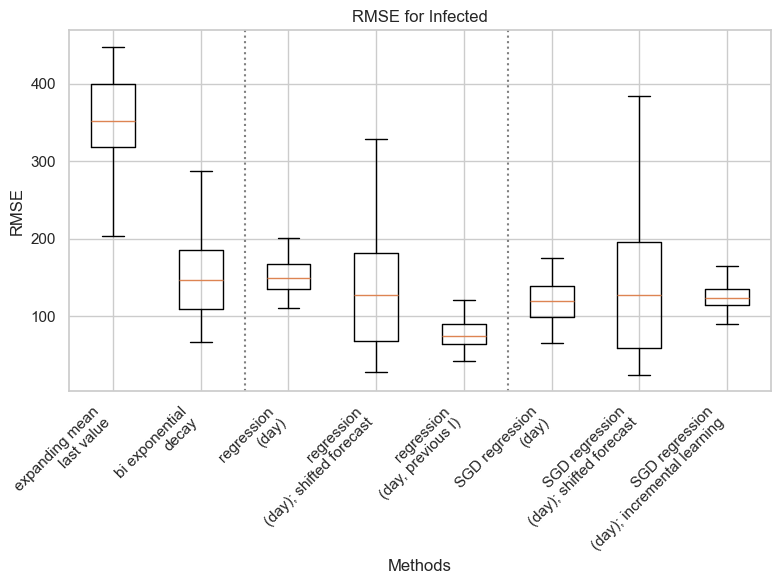

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных из CSV
rmse_df = pd.read_csv('rmse_I_results.csv')
# changing order and dropping expanding_mean
rmse_df = rmse_df[['mean_const', 'bi_exp_decay', 
                   'polynom_of_day', 'polynom_of_day_with_shift', 
                           'polynom_of_day_prev_I',  
                   'polynom_SGDReg', 'polynom_SGDReg_with_rollingshift', 
                           'polynom_SGDReg_with_future_training']]

new_x_labels = ['expanding mean\nlast value', 
                #'expanding mean', 
                'bi exponential\ndecay', 
                'regression\n(day)', 'regression\n(day); shifted forecast', 
                    'regression\n(day, previous I)', 
                'SGD regression\n(day)', 'SGD regression\n(day); shifted forecast', 
                    'SGD regression\n(day); incremental learning']
#rmse_I_df.columns
# Установка стиля для графиков
#sns.set(style="whitegrid")

# Создание боксплота
plt.figure(figsize=(8,6))  # Установка размера графика
plt.boxplot(rmse_df, showfliers=False)

# Настройка заголовка и меток
plt.title('RMSE for Infected')
plt.xlabel('Methods')
plt.ylabel('RMSE')

# Поворот меток по оси X для лучшей читаемости
plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
           labels=new_x_labels, rotation=45, ha='right')

plt.axvline(2.5, ls=':', color='gray')
plt.axvline(5.5, ls=':', color='gray')
#plt.ylim(0,500)
# Показать график
plt.tight_layout()  # Автоматическая настройка отступов

plt.savefig('rmse_I_boxplot.pdf', format='pdf', dpi=300, bbox_inches='tight')

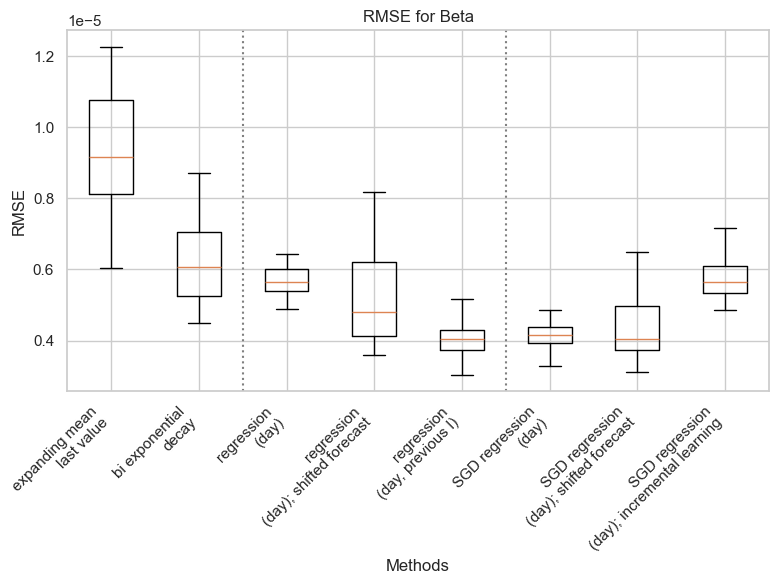

In [91]:
# Загрузка данных из CSV
rmse_df = pd.read_csv('rmse_Beta_results.csv').drop(columns=['expanding_mean'])
# changing order and dropping expanding_mean
rmse_df = rmse_df[['mean_const', 'bi_exp_decay', 
                   'polynom_of_day', 'polynom_of_day_with_shift', 
                           'polynom_of_day_prev_I',  
                   'polynom_SGDReg', 'polynom_SGDReg_with_rollingshift', 
                           'polynom_SGDReg_with_future_training']]

new_x_labels = ['expanding mean\nlast value', 
                #'expanding mean', 
                'bi exponential\ndecay', 
                'regression\n(day)', 'regression\n(day); shifted forecast', 
                    'regression\n(day, previous I)', 
                'SGD regression\n(day)', 'SGD regression\n(day); shifted forecast', 
                    'SGD regression\n(day); incremental learning']
# Установка стиля для графиков
#sns.set(style="whitegrid")

# Создание боксплота
plt.figure(figsize=(8,6))  # Установка размера графика
plt.boxplot(rmse_df, showfliers=False)

# Настройка заголовка и меток
plt.title('RMSE for Beta')
plt.xlabel('Methods')
plt.ylabel('RMSE')

# Поворот меток по оси X для лучшей читаемости
plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
           labels=new_x_labels, rotation=45, ha='right')

#plt.ylim(0,1.5e-5)
plt.axvline(2.5, ls=':', color='gray')
plt.axvline(5.5, ls=':', color='gray')

# Показать график
plt.tight_layout()  # Автоматическая настройка отступов
plt.savefig('rmse_Beta_boxplot.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()